In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from astropy.table import Table
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.optimize as op
import corner
import emcee
%matplotlib notebook

In [2]:
catalog = fits.open('Catalogs/age_calibrators.fits')

In [3]:
ewha = catalog[1].data['ewha']
ewha_error = catalog[1].data['ewha_error']
lewha = np.log10(ewha)
lewha_error = np.array([np.nanstd(np.log10(np.random.normal(ha_i,eha_i,2000))) for ha_i,eha_i in zip(ewha,ewha_error)])
age = catalog[1].data['age']
lage = np.log10(catalog[1].data['age'])
ra = catalog[1].data['ra']
dec = catalog[1].data['dec']
ra_gaia = catalog[1].data['ra_gaia']
dec_gaia = catalog[1].data['dec_gaia']
g = catalog[1].data['g_corr']
rp = catalog[1].data['rp_corr']
g_snr = catalog[1].data['phot_g_mean_flux']/catalog[1].data['phot_g_mean_flux_error']
rp_snr = catalog[1].data['phot_rp_mean_flux']/catalog[1].data['phot_rp_mean_flux_error']
lhalbol = catalog[1].data['lhalbol']
log_lhalbol = np.log10(lhalbol)
log_lhalbol_error = np.ones(len(lhalbol))*0.1
parallax = catalog[1].data['parallax']
g_abs = g - 5*(np.log10(1e3/parallax)-1)
source_id = catalog[1].data['source_id_gaia']
g_rp = g-rp
group_name = catalog[1].data['group_name']
group_num = catalog[1].data['group_num']


/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

In [4]:
#source_ids = Table()
#source_ids['source_id'] = catalog[1].data['source_id_gaia']
#source_ids['ra'] = catalog[1].data['ra_gaia']
#source_ids['dec'] = catalog[1].data['dec_gaia']
#source_ids.write('Catalogs/age_calibrators_source_id.vot',format='votable',overwrite=True)


In [5]:
mask_keep =  (ewha/ewha_error>1) * (~np.isnan(ewha_error)) * (rp_snr > 10) * (group_name!='ARG') * (g_rp > 0.8) #* (ewha>0.75)


/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


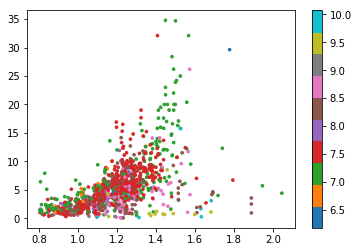

In [6]:
plt.scatter(g_rp[mask_keep],ewha[mask_keep],c=np.log10(age[mask_keep]),s=7,cmap='tab10')
plt.colorbar()
#plt.scatter(g_rp,ewha,c=np.log10(age),s=6)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


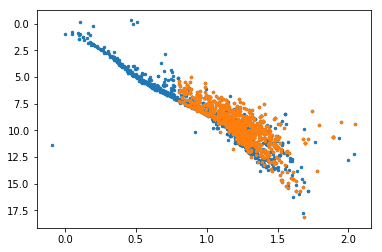

In [7]:
remove = g_abs < 9*g_rp - 3.5
plt.scatter(g_rp,g_abs,s=6)
plt.scatter(g_rp[mask_keep],g_abs[mask_keep],s=6)
#plt.scatter(g_rp[remove],g_abs[remove],s=6,color='r')
plt.gca().invert_yaxis()

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


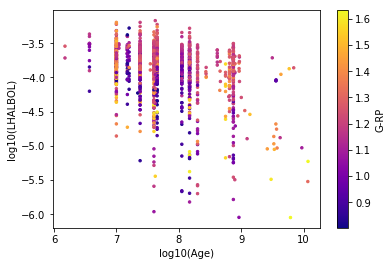

In [8]:
N1 = len(np.log10(age))



plt.scatter(np.log10(age),#+np.random.rand(N1)*0.1,
            np.log10(lhalbol),
            c=(g_rp),
            cmap='plasma',s=6)
plt.colorbar(label='G-RP')
plt.xlabel('log10(Age)')
plt.ylabel('log10(LHALBOL)')
plt.show()

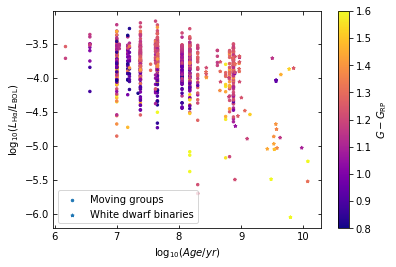

In [9]:
mask_binaries = np.isnan(group_num)
vmin = 0.8
vmax = 1.6
plt.scatter(np.log10(age[mask_keep*~mask_binaries]),#+np.random.rand(N1)*0.1,
            np.log10(lhalbol[mask_keep*~mask_binaries]),
            c=(g_rp[mask_keep*~mask_binaries]),
            cmap='plasma',s=6, label='Moving groups',vmin=vmin,vmax=vmax)
plt.scatter(np.log10(age[mask_keep*mask_binaries]),#+np.random.rand(N1)*0.1,
            np.log10(lhalbol[mask_keep*mask_binaries]),
            c=(g_rp[mask_keep*mask_binaries]),
            cmap='plasma',s=10, label='White dwarf binaries',vmin=vmin,vmax=vmax,
            marker='*')
plt.colorbar(label=r'$G-G_{\rm RP}$')
plt.xlabel(r'$\log _{10}(Age/yr)$')
plt.ylabel(r'$\log _{10}(L_{\rm H\alpha}/L_{\rm BOL})$')
plt.legend()
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('y',which='minor',direction='in',right=True)
plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/ageactivity.png',dpi=300)
plt.show()


In [10]:
def west2008(x,a,b,n,l):
    lhalbol = np.ones(len(x))*np.nan
    mask = x < l
    lhalbol[mask] = a/(x[mask]**n-l**n) - b
    return lhalbol

In [11]:
#age_bin = np.linpsace(np.nanmin(lage),np.nanmax(lage))
mask_active = (ewha > ewha_error) * (ewha >= 1)
mask_inactive = (ewha > ewha_error) * (ewha < 1)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
wd_binaries = np.isnan(group_num)

In [13]:
def fit_halpha(params,z,x):

    a0,a1,a2,a3,a4,a5 = params

    
    halpha_model = (a0 + a1*z + a2*z**2 +
                    a3*x + a4*x**2 +
                    a5*z*x)


    return halpha_model
        

def lnlike_color_abs_age(params_x,g_rp_x,log10age_x,log10ewha_x,log10ewha_error_x):
    model_halpha = fit_halpha(params_x,g_rp_x,log10age_x)
    return -0.5*np.sum((model_halpha - log10ewha_x)**2/(log10ewha_error_x**2)) 


In [14]:
mask_color_1 = (0.8 <= g_rp) * (g_rp < 1.12)#Early Ms partialy convective
mask_color_2 = (1.12 <= g_rp) * (g_rp < 1.43)#Mid Ms fully convective
mask_color_3 = (1.43 <= g_rp) * (g_rp < 1.65)#Ultracool dwarfs 

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less

In [42]:
mask_nan_inf_color_1 = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
                       * (log_lhalbol_error!=0) * mask_color_1)

ini_params = np.ones(6)*0.1

nll = lambda *args: -lnlike_color_abs_age(*args)
res_all_color_1 = op.minimize(nll, ini_params, args=(g_rp[mask_nan_inf_color_1],lage[mask_nan_inf_color_1],
                                             log_lhalbol[mask_nan_inf_color_1],
                                             log_lhalbol_error[mask_nan_inf_color_1]))

ndim, nwalkers = len(res_all_color_1.x), 100

p0 = np.array([res_all_color_1.x+np.random.rand()*0.1 for i in range(nwalkers)])

sampler_color_1 = emcee.EnsembleSampler(nwalkers, ndim, lnlike_color_abs_age, args=[g_rp[mask_nan_inf_color_1],
                                                                                    lage[mask_nan_inf_color_1],
                                                                                    log_lhalbol[mask_nan_inf_color_1],
                                                                                    log_lhalbol_error[mask_nan_inf_color_1]])
sampler_color_1.run_mcmc(p0, 10000)

chain_color_1 = sampler_color_1.chain[:,500:,:]
flat_samples_color_1 = chain_color_1.reshape((-1,ndim))

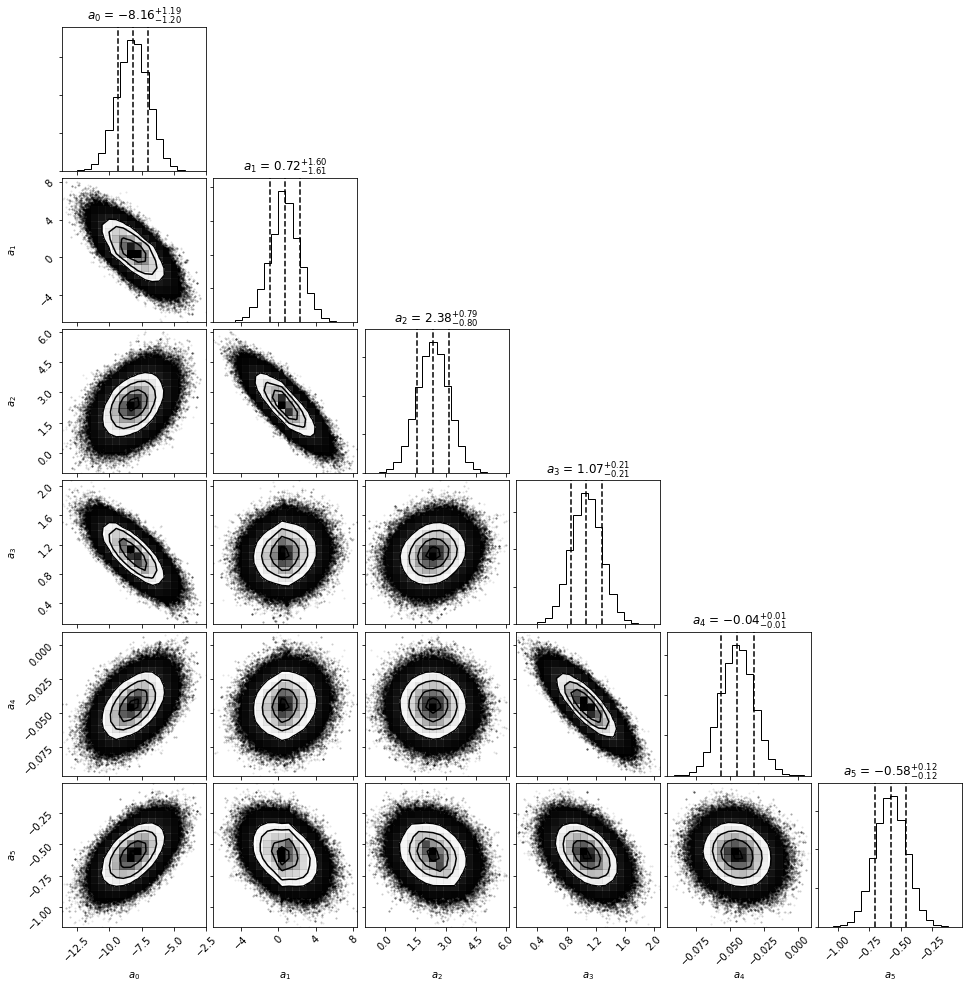

In [43]:
labels = ['$a_0$','$a_1$','$a_2$','$a_3$','$a_4$','$a_5$']

fig = corner.corner(flat_samples_color_1, labels=labels, quantiles=[.16,.50,.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
fig.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/corner_fit_color_1.png',dpi=300)

In [44]:
mask_nan_inf_color_2 = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
                       * (log_lhalbol_error!=0) * mask_color_2)

ini_params = np.ones(6)*0.1

nll = lambda *args: -lnlike_color_abs_age(*args)
res_all_color_2 = op.minimize(nll, ini_params, args=(g_rp[mask_nan_inf_color_2],lage[mask_nan_inf_color_2],
                                             log_lhalbol[mask_nan_inf_color_2],
                                             log_lhalbol_error[mask_nan_inf_color_2]))

ndim, nwalkers = len(res_all_color_2.x), 100

p0 = np.array([res_all_color_2.x+np.random.rand()*0.1 for i in range(nwalkers)])

sampler_color_2 = emcee.EnsembleSampler(nwalkers, ndim, lnlike_color_abs_age, args=[g_rp[mask_nan_inf_color_2],
                                                                                    lage[mask_nan_inf_color_2],
                                                                                    log_lhalbol[mask_nan_inf_color_2],
                                                                                    log_lhalbol_error[mask_nan_inf_color_2]])
sampler_color_2.run_mcmc(p0, 10000)

chain_color_2 = sampler_color_2.chain[:,500:,:]
flat_samples_color_2 = chain_color_2.reshape((-1,ndim))

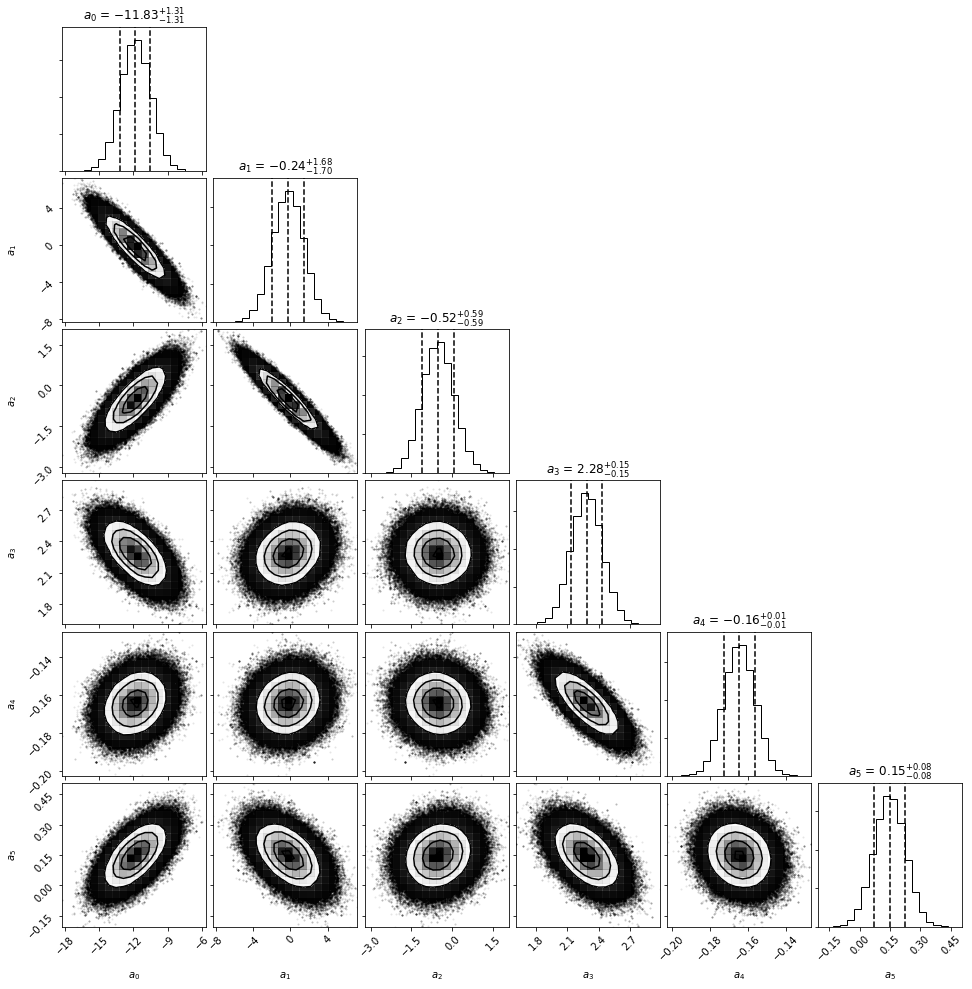

In [45]:
labels = ['$a_0$','$a_1$','$a_2$','$a_3$','$a_4$','$a_5$']

fig = corner.corner(flat_samples_color_2, labels=labels, quantiles=[.16,.50,.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
fig.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/corner_fit_color_2.png',dpi=300)

In [46]:
mask_nan_inf_color_3 = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
                       * (log_lhalbol_error!=0) * mask_color_3)

ini_params = np.ones(6)*0.1

nll = lambda *args: -lnlike_color_abs_age(*args)
res_all_color_3 = op.minimize(nll, ini_params, args=(g_rp[mask_nan_inf_color_3],lage[mask_nan_inf_color_3],
                                             log_lhalbol[mask_nan_inf_color_3],
                                             log_lhalbol_error[mask_nan_inf_color_3]))

ndim, nwalkers = len(res_all_color_3.x), 100

p0 = np.array([res_all_color_3.x+np.random.rand()*0.1 for i in range(nwalkers)])

sampler_color_3 = emcee.EnsembleSampler(nwalkers, ndim, lnlike_color_abs_age, args=[g_rp[mask_nan_inf_color_3],
                                                                                    lage[mask_nan_inf_color_3],
                                                                                    log_lhalbol[mask_nan_inf_color_3],
                                                                                    log_lhalbol_error[mask_nan_inf_color_3]])
sampler_color_3.run_mcmc(p0, 10000)

chain_color_3 = sampler_color_3.chain[:,500:,:]
flat_samples_color_3 = chain_color_3.reshape((-1,ndim))

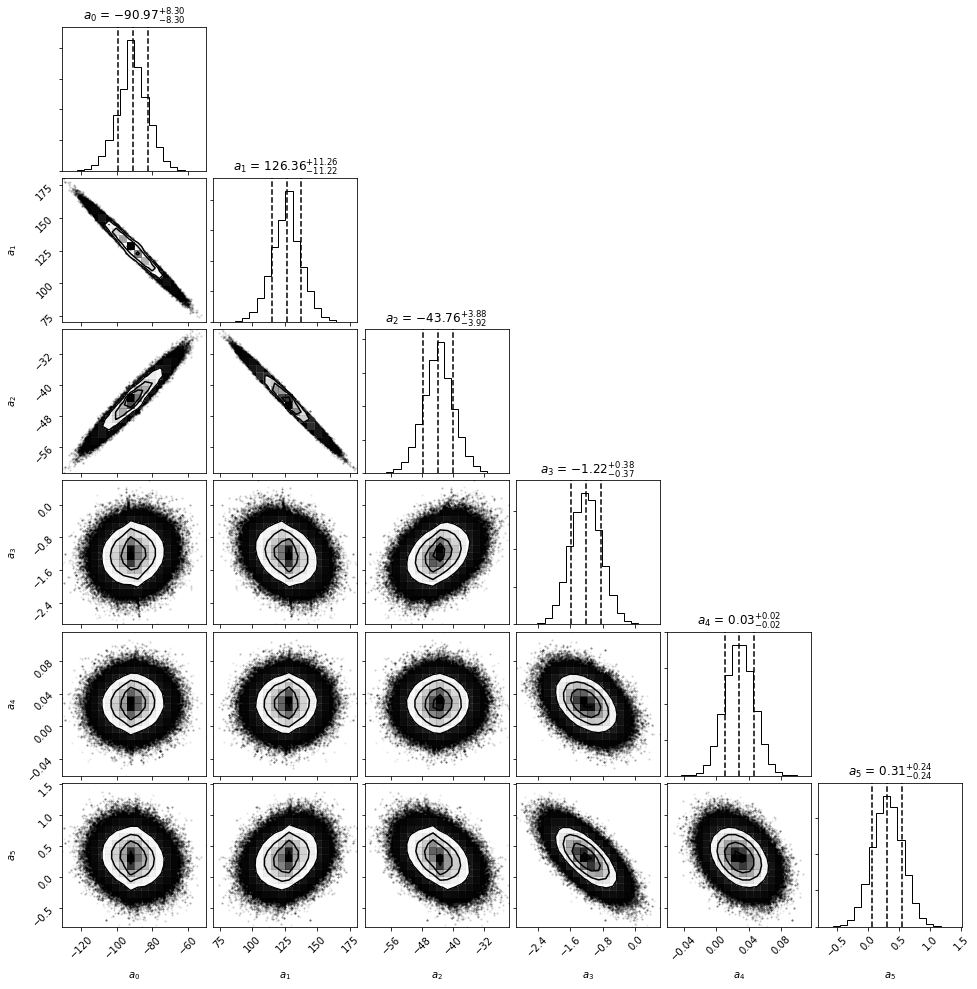

In [47]:
labels = ['$a_0$','$a_1$','$a_2$','$a_3$','$a_4$','$a_5$']

fig = corner.corner(flat_samples_color_3, labels=labels, quantiles=[.16,.50,.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
fig.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/corner_fit_color_3.png',dpi=300)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykern

(-5.8, -3)

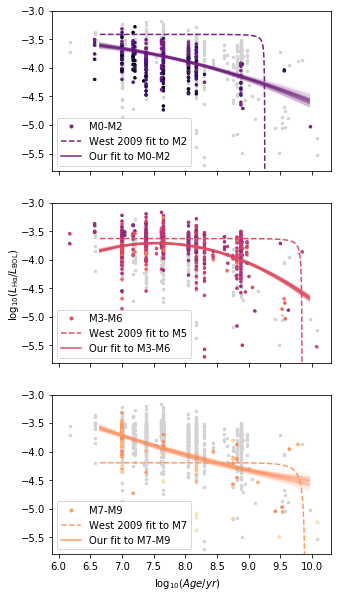

In [59]:
vmin = 0.8
vmax = 1.65
s=6

cmap = cm.magma
norm = Normalize(vmin=vmin, vmax=vmax)

color1 = cmap(norm(1.09)) #M2
color2 = cmap(norm(1.32)) #M5
color3 = cmap(norm(1.47)) #M7

x = np.linspace(0,9,2000)

idx_color_1 = np.random.randint(len(flat_samples_color_1[:,0]), size=100)
idx_color_2 = np.random.randint(len(flat_samples_color_2[:,0]), size=100)
idx_color_3 = np.random.randint(len(flat_samples_color_3[:,0]), size=100)

f, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(5,10))

ax1.scatter(lage[mask_keep],log_lhalbol[mask_keep],s=s,color='lightgrey')
ax1.scatter(lage[mask_nan_inf_color_1],log_lhalbol[mask_nan_inf_color_1],c=g_rp[mask_nan_inf_color_1],
            vmin=vmin,vmax=vmax,cmap='magma',s=s)
ax1.plot([0,0],[0,0],'.',color=color1,label='M0-M2')
ax1.plot(np.log10(x*1e9),west2008(x,0.106,3.38,2.0,1.8),color=color1,linestyle='--',label='West 2009 fit to M2')
for idx_j in idx_color_1:
    ax1.plot(np.log10(x*1e9),fit_halpha(flat_samples_color_1[idx_j,:],1.09,np.log10(x*1e9)),color=color1,alpha=0.05)
ax1.plot([0,0],[0,0],'-',color=color1,label='Our fit to M0-M2') 
ax1.legend(loc=3)
    
ax2.scatter(lage[mask_keep],log_lhalbol[mask_keep],s=s,color='lightgrey')
ax2.scatter(lage[mask_nan_inf_color_2],log_lhalbol[mask_nan_inf_color_2],c=g_rp[mask_nan_inf_color_2],
            vmin=vmin,vmax=vmax,cmap='magma',s=s)
ax2.plot([0,0],[0,0],'.',color=color2,label='M3-M6')
ax2.plot(np.log10(x*1e9),west2008(x,2.85,3.57,2.0,7.0),color=color2,linestyle='--',label='West 2009 fit to M5')
for idx_j in idx_color_2:
    ax2.plot(np.log10(x*1e9),fit_halpha(flat_samples_color_2[idx_j,:],1.32,np.log10(x*1e9)),color=color2,alpha=0.05)
ax2.plot([0,0],[0,0],'-',color=color2,label='Our fit to M3-M6')    
ax2.legend(loc=3)

ax3.scatter(lage[mask_keep],log_lhalbol[mask_keep],s=s,color='lightgrey')
ax3.scatter(lage[mask_nan_inf_color_3],log_lhalbol[mask_nan_inf_color_3],c=g_rp[mask_nan_inf_color_3],
            vmin=vmin,vmax=vmax,cmap='magma',s=s)
ax3.plot([0,0],[0,0],'.',color=color3,label='M7-M9')
ax3.plot(np.log10(x*1e9),west2008(x,11.8,4.01,2.0,8.0),color=color3,linestyle='--',label='West 2009 fit to M7')
for idx_j in idx_color_3:
    ax3.plot(np.log10(x*1e9),fit_halpha(flat_samples_color_3[idx_j,:],1.47,np.log10(x*1e9)),color=color3,alpha=0.05)
ax3.plot([0,0],[0,0],'-',color=color3,label='Our fit to M7-M9')    
ax3.legend(loc=3)


f.text(0.5, 0.08, r'$\log _{10}(Age/yr)$', ha='center')
f.text(0.000, 0.5, r'$\log _{10}(L_{\rm H\alpha}/L_{\rm BOL})$', va='center', rotation='vertical')

plt.xlim(5.9,10.3)
plt.ylim(-5.8,-3)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Use

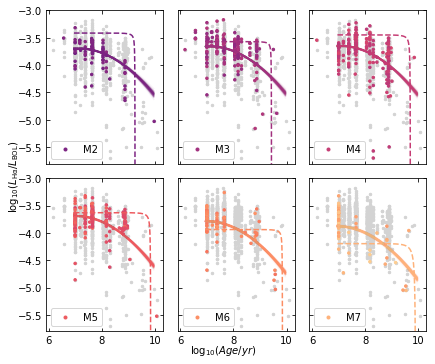

In [20]:
#color_bin = np.array([0.8,1.12,1.43,1.65])
color_bin = np.array([1.06,1.12,1.2,1.27,1.36,1.43,1.52,1.6,1.65])
n_fits = 10
idx = np.random.randint(len(flat_samples[:,0]), size=100)

mask1 = (g_rp > color_bin[0]) * (g_rp < color_bin[1]) * mask_keep
mask2 = (g_rp > color_bin[1]) * (g_rp < color_bin[2]) * mask_keep
mask3 = (g_rp > color_bin[2]) * (g_rp < color_bin[3]) * mask_keep
mask4 = (g_rp > color_bin[3]) * (g_rp < color_bin[4]) * mask_keep
mask5 = (g_rp > color_bin[4]) * (g_rp < color_bin[5]) * mask_keep
mask6 = (g_rp > color_bin[5]) * (g_rp < color_bin[6]) * mask_keep

vmin = 0.8
vmax = 1.6

cmap = cm.magma
norm = Normalize(vmin=vmin, vmax=vmax)

color1 = cmap(norm(1.09)) #M2
color2 = cmap(norm(1.16)) #M3
color3 = cmap(norm(1.23)) #M4
color4 = cmap(norm(1.32)) #M5
color5 = cmap(norm(1.41)) #M6
color6 = cmap(norm(1.47)) #M7

x = np.linspace(0,9,1000)

f,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,sharey=True,sharex=True,figsize=(6,5))
ax1.scatter(np.log10(age[mask_keep]),np.log10(lhalbol[mask_keep]),s=6,color='lightgrey')
ax1.scatter(np.log10(age[mask1]),
            np.log10(lhalbol[mask1]),s=6,c=g_rp[mask1],vmax=vmax,vmin=vmin,
            cmap='magma')
ax1.plot([0,0],[0,0],'.',color=color1,label='M2')
ax1.plot(np.log10(x*1e9),west2008(x,0.106,3.38,2.0,1.8),color=color1,linestyle='--')
for idx_j in idx:
    ax1.plot(np.log10(x*1e9),fit_halpha(flat_samples[idx_j,:],1.09,np.log10(x*1e9)),color=color1,alpha=0.05)

ax2.scatter(np.log10(age[mask_keep]),np.log10(lhalbol[mask_keep]),s=6,color='lightgrey')
ax2.scatter(np.log10(age[mask2]),
            np.log10(lhalbol[mask2]),s=6,c=g_rp[mask2],vmax=vmax,vmin=vmin,
            cmap='magma')
ax2.plot([0,0],[0,0],'.',color=color2,label='M3')
ax2.plot(np.log10(x*1e9),west2008(x,0.213,3.54,2.0,2.7),color=color2,linestyle='--')
for idx_j in idx:
    ax2.plot(np.log10(x*1e9),fit_halpha(flat_samples[idx_j,:],1.16,np.log10(x*1e9)),color=color2,alpha=0.05)

ax3.scatter(np.log10(age[mask_keep]),np.log10(lhalbol[mask_keep]),s=6,color='lightgrey')
ax3.scatter(np.log10(age[mask3]),
            np.log10(lhalbol[mask3]),s=6,c=g_rp[mask3],vmax=vmax,vmin=vmin,
            cmap='magma')
ax3.plot([0,0],[0,0],'.',color=color3,label='M4')
ax3.plot(np.log10(x*1e9),west2008(x,1.41,3.39,2.0,5.0),color=color3,linestyle='--')
for idx_j in idx:
    ax3.plot(np.log10(x*1e9),fit_halpha(flat_samples[idx_j,:],1.23,np.log10(x*1e9)),color=color3,alpha=0.05)

ax4.scatter(np.log10(age[mask_keep]),np.log10(lhalbol[mask_keep]),s=6,color='lightgrey')
ax4.scatter(np.log10(age[mask4]),
            np.log10(lhalbol[mask4]),s=6,c=g_rp[mask4],vmax=vmax,vmin=vmin,
            cmap='magma')
ax4.plot([0,0],[0,0],'.',color=color4,label='M5')
ax4.plot(np.log10(x*1e9),west2008(x,2.85,3.57,2.0,7.0),color=color4,linestyle='--')
for idx_j in idx:
    ax4.plot(np.log10(x*1e9),fit_halpha(flat_samples[idx_j,:],1.32,np.log10(x*1e9)),color=color4,alpha=0.05)

ax5.scatter(np.log10(age[mask_keep]),np.log10(lhalbol[mask_keep]),s=6,color='lightgrey')
ax5.scatter(np.log10(age[mask5]),
            np.log10(lhalbol[mask5]),s=6,c=g_rp[mask5],vmax=vmax,vmin=vmin,
            cmap='magma')
ax5.plot([0,0],[0,0],'.',color=color5,label='M6')
ax5.plot(np.log10(x*1e9),west2008(x,1.78,3.90,2.0,7.0),color=color5,linestyle='--')
for idx_j in idx:
    ax5.plot(np.log10(x*1e9),fit_halpha(flat_samples[idx_j,:],1.41,np.log10(x*1e9)),color=color5,alpha=0.05)

ax6.scatter(np.log10(age[mask_keep]),np.log10(lhalbol[mask_keep]),s=6,color='lightgrey')
ax6.scatter(np.log10(age[mask6]),
            np.log10(lhalbol[mask6]),s=6,c=g_rp[mask6],vmax=vmax,vmin=vmin,
            cmap='magma')
ax6.plot([0,0],[0,0],'.',color=color6,label='M7')
ax6.plot(np.log10(x*1e9),west2008(x,11.8,4.01,2.0,8.0),color=color6,linestyle='--')
for idx_j in idx:
    ax6.plot(np.log10(x*1e9),fit_halpha(flat_samples[idx_j,:],1.47,np.log10(x*1e9)),color=color6,alpha=0.05)


for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.legend(loc=3)
    ax.tick_params('both',direction='in',top=True,right=True)
    ax.tick_params('y',which='minor',direction='in',right=True)

f.text(0.5, 0.008, r'$\log _{10}(Age/yr)$', ha='center')
f.text(0.000, 0.5, r'$\log _{10}(L_{\rm H\alpha}/L_{\rm BOL})$', va='center', rotation='vertical')

plt.xlim(5.9,10.3)
plt.ylim(-5.8,-3)
plt.tight_layout()
plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/age_activity_rel_fit.png',
            dpi=300,tight_layout=True)
plt.show()

In [27]:
def calc_ewha(lhalbol0,g_rp0):
    chi_douglas2014 = np.array([6.6453,6.0334,5.2658,4.4872,3.5926,2.4768,1.7363,1.2057,0.6122,0.3522])*1e-5
    g_rp_kiman2019 = np.array([0.93,1.01,1.09,1.16,1.23,1.32,1.41,1.47,1.57,1.63])
    p = np.polyfit(g_rp_kiman2019,chi_douglas2014,4)
    N = len(lhalbol0)
    ewha0 = np.ones(N)*np.nan
    mask = (0.8 <= g_rp0) * (g_rp0 <=1.65)
    ewha0[mask] = lhalbol0[mask]/np.polyval(p,g_rp0[mask])
    
    return ewha0

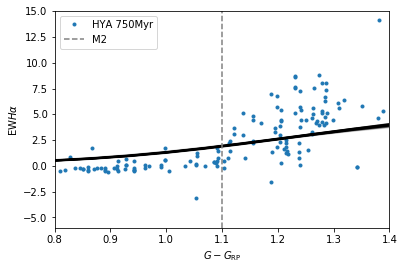

In [41]:
age0 = 750
mask_age = age/1e6 == age0
g_rp_fit = np.linspace(0.8,1.4,10)
plt.plot(g_rp[mask_age],ewha[mask_age],'.',label='HYA 750Myr')
for idx_j in idx:
    ewha_fit = calc_ewha(10**fit_halpha(flat_samples[idx_j,:],g_rp_fit,np.log10(age0*1e6)),g_rp_fit)
    plt.plot(g_rp_fit,ewha_fit,color='k',alpha=0.1)
plt.axvline(x=1.1,color='gray',linestyle='--',label='M2')
plt.xlim(0.8,1.4)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'EW$H\alpha$')
plt.legend()

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid va

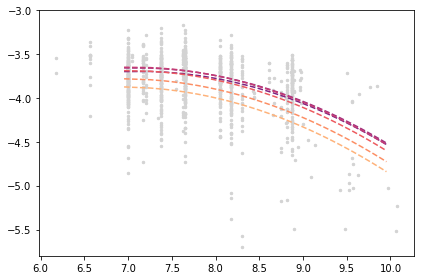

In [147]:
#color_bin = np.array([0.8,1.12,1.43,1.65])
color_bin = np.array([1.06,1.12,1.2,1.27,1.36,1.43,1.52,1.6,1.65])

mask1 = (g_rp > color_bin[0]) * (g_rp < color_bin[1]) * mask_keep
mask2 = (g_rp > color_bin[1]) * (g_rp < color_bin[2]) * mask_keep
mask3 = (g_rp > color_bin[2]) * (g_rp < color_bin[3]) * mask_keep
mask4 = (g_rp > color_bin[3]) * (g_rp < color_bin[4]) * mask_keep
mask5 = (g_rp > color_bin[4]) * (g_rp < color_bin[5]) * mask_keep
mask6 = (g_rp > color_bin[5]) * (g_rp < color_bin[6]) * mask_keep

vmin = 0.8
vmax = 1.6

cmap = cm.magma
norm = Normalize(vmin=vmin, vmax=vmax)

color1 = cmap(norm(1.09)) #M2
color2 = cmap(norm(1.16)) #M3
color3 = cmap(norm(1.23)) #M4
color4 = cmap(norm(1.32)) #M5
color5 = cmap(norm(1.41)) #M6
color6 = cmap(norm(1.47)) #M7

x = np.linspace(0,9,1000)


plt.scatter(np.log10(age[mask_keep]),np.log10(lhalbol[mask_keep]),s=6,color='lightgrey')
plt.plot(np.log10(x*1e9),fit_halpha(res_all.x,1.09,np.log10(x*1e9)),color=color1,linestyle='--')
plt.plot(np.log10(x*1e9),fit_halpha(res_all.x,1.16,np.log10(x*1e9)),color=color2,linestyle='--')
plt.plot(np.log10(x*1e9),fit_halpha(res_all.x,1.23,np.log10(x*1e9)),color=color3,linestyle='--')
plt.plot(np.log10(x*1e9),fit_halpha(res_all.x,1.32,np.log10(x*1e9)),color=color4,linestyle='--')
plt.plot(np.log10(x*1e9),fit_halpha(res_all.x,1.41,np.log10(x*1e9)),color=color5,linestyle='--')
plt.plot(np.log10(x*1e9),fit_halpha(res_all.x,1.47,np.log10(x*1e9)),color=color6,linestyle='--')

plt.ylim(-5.8,-3)
plt.tight_layout()
plt.show()